# Sheet 6

## 1 Autoencoders: theory and practice

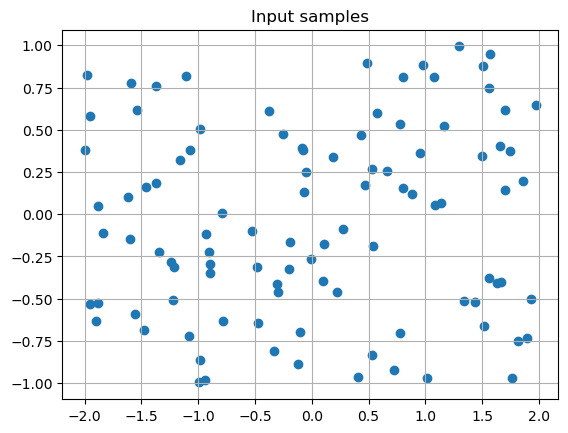

In [1]:
import torch
import matplotlib.pyplot as plt

# create 1000 uniform samples from a rectangle [-2, 2] x [-1, 1]
num_samples = 100
data = torch.zeros(num_samples, 2)
data[:, 0] = torch.rand(num_samples) * 4 - 2
data[:, 1] = torch.rand(num_samples) * 2 - 1

# plot the samples
plt.scatter(data[:, 0], data[:, 1])
plt.title("Input samples")
plt.grid(True)
plt.show()

In [2]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare data loader
dataset = TensorDataset(data, data)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

# get batched data from the data loader
x, y = next(iter(data_loader))
print("x.shape:", x.shape)
print("y.shape:", y.shape)
print("all x == y:", torch.all(x == y).item())

x.shape: torch.Size([8, 2])
y.shape: torch.Size([8, 2])
all x == y: True


### (a)

In [3]:
# TODO: define the Autoencoder architecture

import torch
from torch import nn
import pytorch_lightning as pl

class Autoencoder(nn.Module):
    def __init__(self, hidden_channels, latent_dim=1, input_dim=2): #hidden channels as list 
        super().__init__()

        # TODO: implement the encoder and decoder
        if hidden_channels == 0:
            self.encoder = nn.Linear(input_dim, latent_dim, bias=False)  # Linear layer with no bias
            self.decoder = nn.Linear(latent_dim, input_dim, bias=False)
        else:
            encoder_layers = []
            current_dim = input_dim
            for h in hidden_channels:
                encoder_layers.append(nn.Linear(current_dim, h))
                encoder_layers.append(nn.ReLU()) 
                current_dim = h
            encoder_layers.append(nn.Linear(current_dim, latent_dim))  # Bottleneck layer
            self.encoder = nn.Sequential(*encoder_layers)
            
            #decoder as mirrored encoder
            decoder_layers = []
            current_dim = latent_dim
            for h in reversed(hidden_channels):
                decoder_layers.append(nn.Linear(current_dim, h))
                decoder_layers.append(nn.ReLU()) 
                current_dim = h
            decoder_layers.append(nn.Linear(current_dim, input_dim))  # Output layer
            self.decoder = nn.Sequential(*decoder_layers)
    

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class AutoencoderModule(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super().__init__()
        self.autoencoder = Autoencoder(**model_kwargs)
        self.loss_curve = []

    def forward(self, x):
        return self.autoencoder(x)

    def configure_optimizers(self):
        # as default use Adam optimizer:
        optimizer = torch.optim.Adam(self.parameters())

        return optimizer
    
    def on_train_start(self):
        self.loss_curve = []
        return super().on_train_start()

    def training_step(self, batch):
        x, _ = batch
        x_hat = self.autoencoder(x)
        loss = nn.MSELoss()(x_hat, x)
        self.loss_curve.append(loss.item())
        return loss

ReLu is a simple and effective non-linearity, therefore it was chosen. The activation was left out for the bottleneck and the output as those should be unconstrained. In the case of PCA no non-linearities are added in the network.

### (b)

In [4]:
# start the training using a PyTorch Lightning Trainer
autoencoder_module_1 = AutoencoderModule(hidden_channels=[20, 10])  # TODO: specify the model here
autoencoder_module_2 = AutoencoderModule(hidden_channels=[50, 50])  # TODO: specify the model here
autoencoder_module_pca = AutoencoderModule(hidden_channels=0)  # TODO: specify the model here

models = [autoencoder_module_1, autoencoder_module_2, autoencoder_module_pca]

In [5]:
for model in models:
    trainer = pl.Trainer(max_epochs=1000)
    print("Model overview:", model)
    trainer.fit(model, data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\sasch\miniconda3\envs\mlph3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: c:\Users\sasch\iCloudDrive\Uni\mlph_w24\sheet06\lightning_logs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 563    | train
----------------------------------------------------
563       Trainable params
0         Non-trainable params
563  

Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=2, bias=True)
    )
  )
)


c:\Users\sasch\miniconda3\envs\mlph3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
c:\Users\sasch\miniconda3\envs\mlph3\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 5.5 K  | train
----------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 4      | train
----------------------------------------------------
4         Trainable params
0         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Linear(in_features=2, out_features=1, bias=False)
    (decoder): Linear(in_features=1, out_features=2, bias=False)
  )
)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


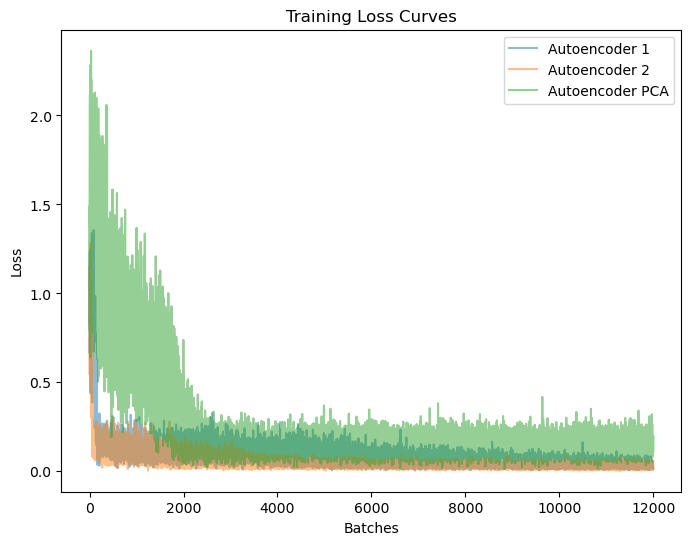

In [6]:
autoencoder_names = ["1", "2", "PCA"]
plt.figure(figsize=(8, 6))
for i, model in enumerate(models):
    plt.plot(model.loss_curve, label=f"Autoencoder {autoencoder_names[i]}", alpha=0.5)
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.show()

Autoencoder 2 gives the best convergence and the lowest loss on the training data. This Autoencoder is the preferred one. PCA has the worrst convergence and the highest loss. It is least suitable for dimensionality reduction.

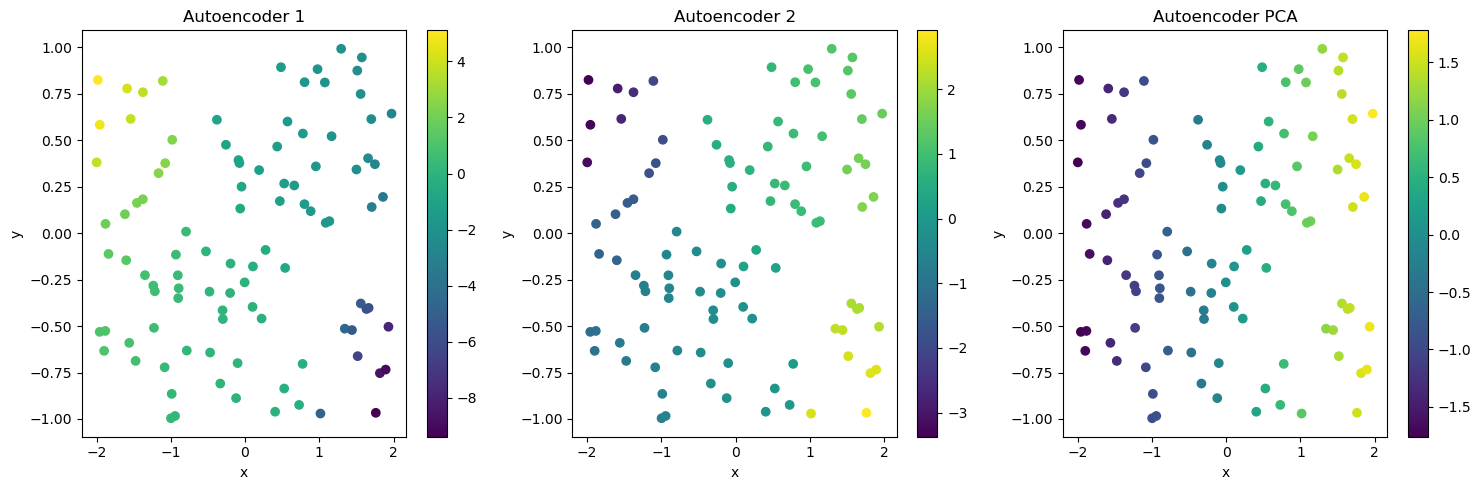

In [7]:
# Visualize latent embeddings
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, model in enumerate(models):
    with torch.no_grad():
        embeddings = model.autoencoder.encoder(data).squeeze().numpy()
    
    scatter = axes[i].scatter(data[:, 0], data[:, 1], c=embeddings, cmap='viridis')
    axes[i].set_title(f"Autoencoder {autoencoder_names[i]}")
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("y")
    fig.colorbar(scatter, ax=axes[i])

plt.tight_layout()
plt.show()

Autoencoder 1 increases with higher x and higher y. Autoencoder 2 intreases with higer x and  lower y. Autoencoder PCA increases with x.

### (c)

#### i)
The random inizialization gives random distributions for all encoders. The more parameters the AE has the more random the distribution will be.
#### ii) 
In the case of AE 1 after training a linear dependency of x and y is expected. In the case of AE 2 after training a parabolic dependency is expected. In the case of AE PCA a constant reletion is expected.

### (d)

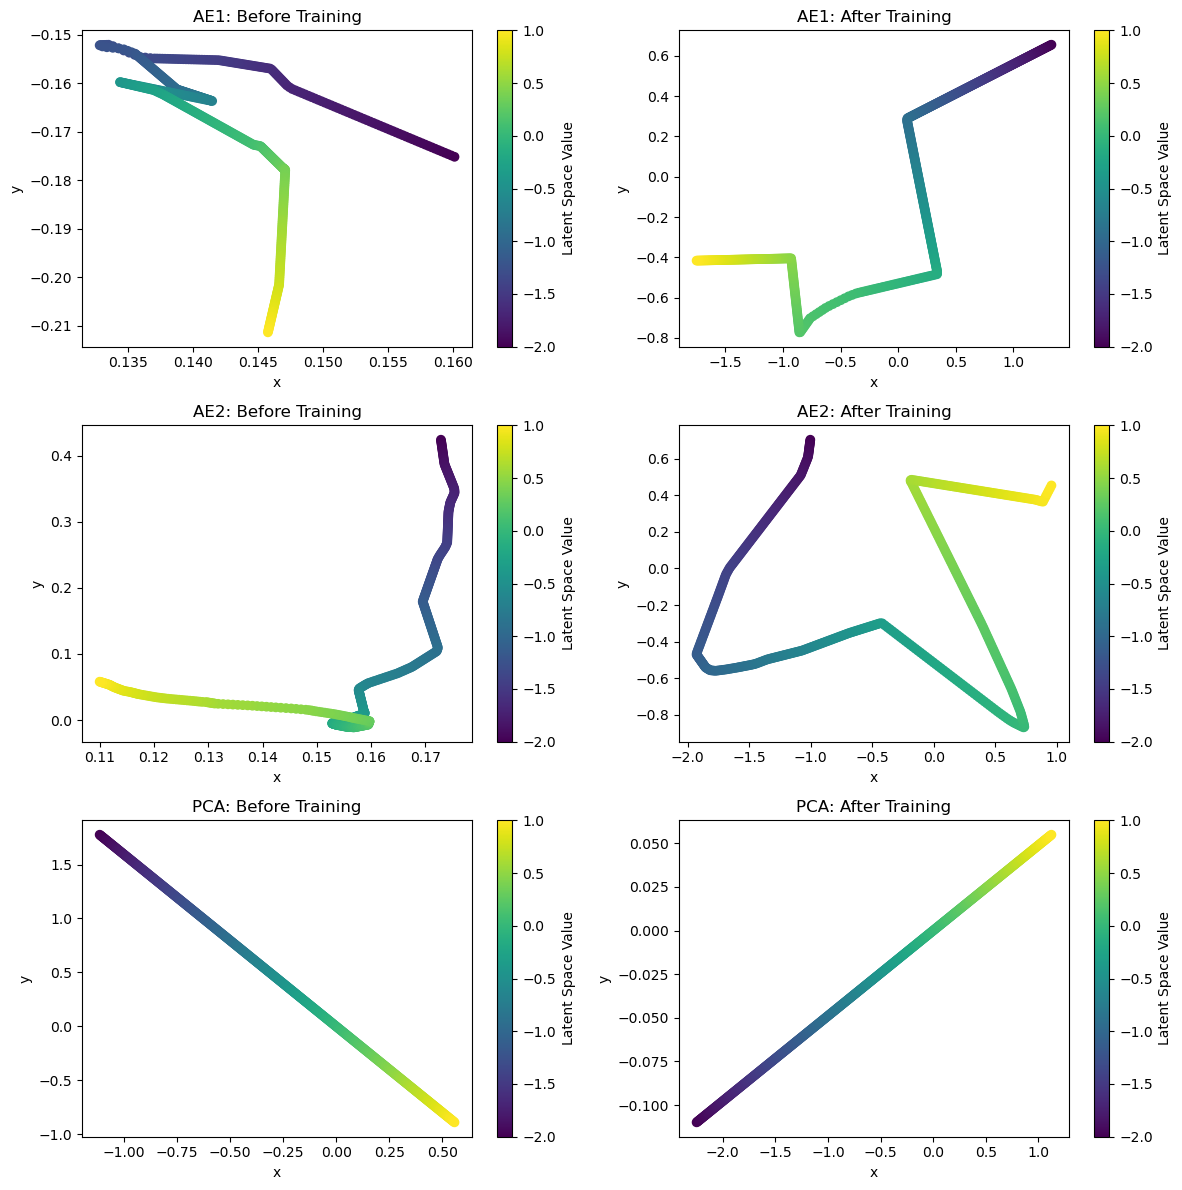

In [ ]:
random_autoencoder_module_1 = AutoencoderModule(hidden_channels=[20, 10])  # TODO: specify the model here
random_autoencoder_module_2 = AutoencoderModule(hidden_channels=[50, 50])  # TODO: specify the model here
random_autoencoder_module_pca = AutoencoderModule(hidden_channels=0)  # TODO: specify the model here

random_models = [random_autoencoder_module_1, random_autoencoder_module_2, random_autoencoder_module_pca]

latent_samples = torch.linspace(-1.5, 1.5, 500).unsqueeze(1)  

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

for i, (model, name) in enumerate(zip(models, ["AE1", "AE2", "PCA"])):
    random_decoder = random_models[i].autoencoder.decoder
    decoder = model.autoencoder.decoder
    
    with torch.no_grad():
        random_outputs = random_decoder(latent_samples)
    sc1 = axs[i, 0].scatter(random_outputs[:, 0], random_outputs[:, 1], c=latent_samples.squeeze(), cmap="viridis")
    axs[i, 0].set_title(f"{name}: Before Training")
    axs[i, 0].set_xlabel("x")
    axs[i, 0].set_ylabel("y")
    plt.colorbar(sc1, ax=axs[i, 0], orientation='vertical', label='Latent Space Value')
    
    # After training
    with torch.no_grad():
        trained_outputs = decoder(latent_samples)
    sc2 = axs[i, 1].scatter(trained_outputs[:, 0], trained_outputs[:, 1], c=latent_samples.squeeze(), cmap="viridis")
    axs[i, 1].set_title(f"{name}: After Training")
    axs[i, 1].set_xlabel("x")
    axs[i, 1].set_ylabel("y")
    plt.colorbar(sc2, ax=axs[i, 1], orientation='vertical', label='Latent Space Value')

plt.tight_layout()
plt.show()

The expectations for the random weigths were fulflilled. For the trained case the AE 1 fulfilled the increase with lower x and less dependency on y despite not observing higher values with decreasing y. AE2 does not correspond to the expected outcome as the highest values were expected in the lower right corner. AE PCA behaves as expected. It increases in the x direction and the y dicection has only minor influence. 

### (e) 
Given a sufficent amount of parameters and non-linearities the model will be able to reconstruct the data due to the universal approximation theorem and the ability to map n datapoints to distinct values in $\mathbb{R}^1$ which can then be reconstructed. The drawback is that the model overfits and loses generalizability in this case as it memorizes the dataset.

### (f)
The training of the encoder will be constrained by the fixed values of the decoder. This results into less efficient, structured and interpreatble latent representations, loss of generalizability due to the focus of the encoder on the discriminator and lower reconstruction quality. Those are the causes of an imbalanced training.

### (g)

In [9]:
autoencoder_module_2_for_retraining = AutoencoderModule(hidden_channels=[50, 50])
trainer = pl.Trainer(max_epochs=1000)
print("Model overview:", autoencoder_module_2_for_retraining)
trainer.fit(autoencoder_module_2_for_retraining, data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 5.5 K  | train
----------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [10]:
import numpy as np
encoded_data = autoencoder_module_2_for_retraining.autoencoder.encoder(data).detach().numpy()

for param in autoencoder_module_2_for_retraining.autoencoder.decoder.parameters():
    param.requires_grad = False

# Initialize encoder weights using a normal distribution (example)
for m in autoencoder_module_2_for_retraining.autoencoder.encoder:
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=1)  # initialization (normal distribution)
        nn.init.zeros_(m.bias)  # Zero initialization for biases

trainer = pl.Trainer(max_epochs=1000)
print("Model overview:", autoencoder_module_2_for_retraining)
trainer.fit(autoencoder_module_2_for_retraining, data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 5.5 K  | train
----------------------------------------------------
2.8 K     Trainable params
2.8 K     Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


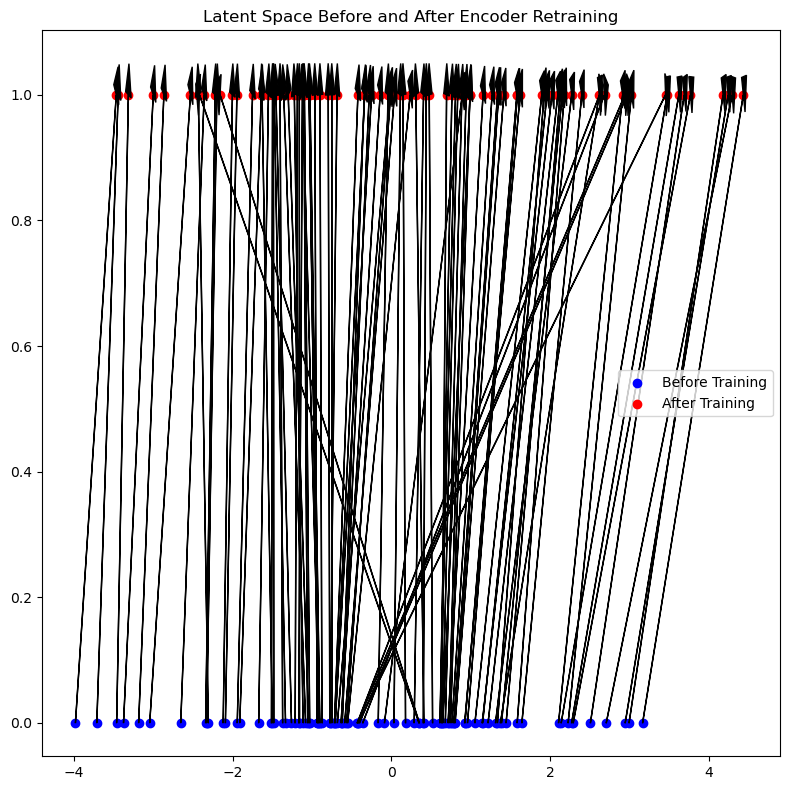

In [11]:
encoded_data_after = autoencoder_module_2_for_retraining.autoencoder.encoder(data).detach().numpy()


fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(encoded_data[:, 0], np.zeros_like(encoded_data[:, 0]), color='blue', label='Before Training')
ax.scatter(encoded_data_after[:, 0], np.zeros_like(encoded_data_after[:, 0])+1, color='red', label='After Training')

# Add arrows showing how the encoder's output changed after retraining
for i in range(len(data)):
    ax.arrow(encoded_data[i, 0], 0, encoded_data_after[i, 0] - encoded_data[i, 0], 1, head_width=0.07, head_length=0.05, fc='black', ec='black')

ax.set_title('Latent Space Before and After Encoder Retraining')
ax.legend()
plt.tight_layout()
plt.show()

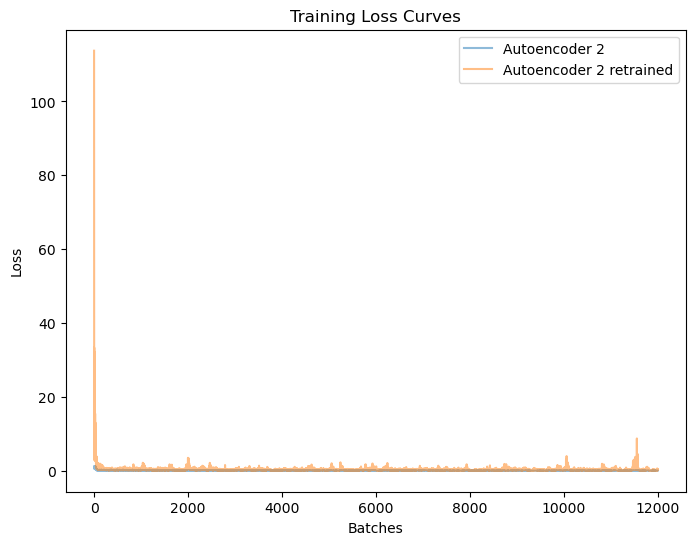

In [12]:
autoencoder_names = ["2", "2 retrained"]
models = [autoencoder_module_2, autoencoder_module_2_for_retraining]
plt.figure(figsize=(8, 6))
for i, model in enumerate(models):
        plt.plot(model.loss_curve, label=f"Autoencoder {autoencoder_names[i]}", alpha=0.5)
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.show()

The new latent space is different from the original one. The spread is determined by the width of the gaussian that is used for the reinitialization. The new latent space is not a scaled version as arrows from the embeddings cross each other. The loss of the retrained network is more variable and higher. This approves the hypothesis.

### (h)

In [13]:
#  Autoencoder module with SGD instead of Adam optimizer

class AutoencoderModule(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super().__init__()
        self.autoencoder = Autoencoder(**model_kwargs)
        self.loss_curve = []

    def forward(self, x):
        return self.autoencoder(x)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters())

        return optimizer
    
    def on_train_start(self):
        self.loss_curve = []
        return super().on_train_start()

    def training_step(self, batch):
        x, _ = batch
        x_hat = self.autoencoder(x)
        loss = nn.MSELoss()(x_hat, x)
        self.loss_curve.append(loss.item())
        return loss

In [14]:
autoencoder_module_2_sgd = AutoencoderModule(hidden_channels=[50, 50])
trainer = pl.Trainer(max_epochs=1000)
print("Model overview:", autoencoder_module_2_sgd)
trainer.fit(autoencoder_module_2_sgd, data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 5.5 K  | train
----------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [18]:
# dataloader with only one batch to make GD instead of SGD
data_loader = DataLoader(dataset, batch_size=100, shuffle=True, drop_last=True)
autoencoder_module_2_gd = AutoencoderModule(hidden_channels=[50, 50])
trainer = pl.Trainer(max_epochs=1000)
print("Model overview:", autoencoder_module_2_gd)
trainer.fit(autoencoder_module_2_gd, data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 5.5 K  | train
----------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=1, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)


c:\Users\sasch\miniconda3\envs\mlph3\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


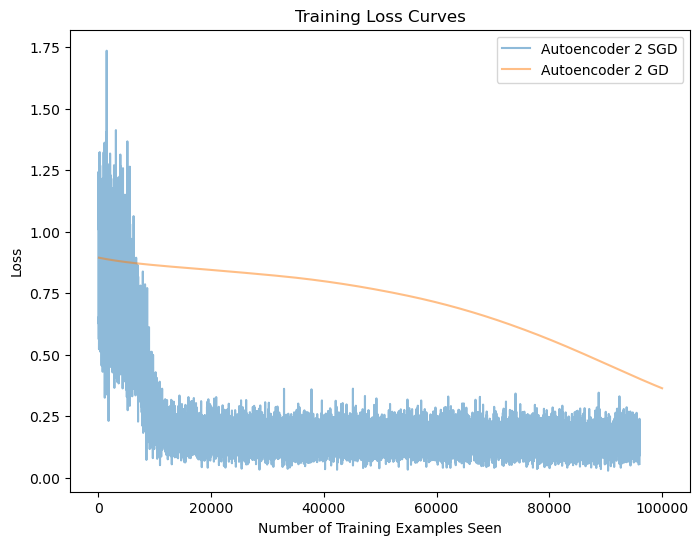

In [38]:
autoencoder_names = ["2 SGD", "2 GD"]
models = [autoencoder_module_2_sgd, autoencoder_module_2_gd]
num_training_examples = [list(range(8, 8*12*1000+1, 8)), list(range(100, 100*1*1000+1, 100))] #num training samples given by step=num batch size, and total train_data_seen=batch_size*num_batches*epochs+
plt.figure(figsize=(8, 6))
for i, model in enumerate(models):
        plt.plot(num_training_examples[i], model.loss_curve, label=f"Autoencoder {autoencoder_names[i]}", alpha=0.5)
plt.xlabel("Number of Training Examples Seen")
plt.ylabel("Loss")
plt.title("Training Loss Curves")
plt.legend()
plt.show()

As expected gradient descent has less variation of the loss but decreases slower. 